<a href="https://colab.research.google.com/github/dkanh6/Machine_Learning_Examples/blob/main/Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First I am going to get the data into this python notebook

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving Part1SubjectHB10.h5 to Part1SubjectHB10 (1).h5
User uploaded file "Part1SubjectHB10 (1).h5" with length 9109466 bytes


now I am going to quickly load in a single dataset so I can get a better idea of what I am working with

In [10]:
import h5py
import numpy as np

# Open the HDF5 file (which act as containers with folders inside that contain two separate objects that have datasets inside them)
filepath = next(iter(uploaded))  # Get the file path of the uploaded file
f = h5py.File(filepath, 'r')  # Open the file

# Initialize states based on the groups found in the HDF5 file
states = list(f.keys())  # This assumes all top-level groups represent different states

# Print basic file attributes and states found
fs = f.attrs['fs'][0]  # Assuming 'fs' is a global attribute for sampling frequency
print(f"Sampling rate: {fs:.1f} Hz")
print(f"States found: {states}")

# Initialize data structures for LFP recordings and segment counts
lfp = {state: [] for state in states}
segment_counts = {state: 0 for state in states}

for state in states:
    group = f[state]  # Access the group corresponding to the state
    segment_ids = list(group.keys())  # List segment IDs within the state
    segment_counts[state] = len(segment_ids)  # Count segments for the state

    for segment_id in segment_ids:
        # Extract and store segment data
        segment_data = np.array(group[segment_id]).astype(float)
        lfp[state].append(segment_data)

# Print the number of segments for each state
for state, count in segment_counts.items():
    print(f"State: {state}, Number of segments: {count}")


Sampling rate: 1000.0 Hz
States found: ['NREM', 'WAKE']
State: NREM, Number of segments: 17
State: WAKE, Number of segments: 38


Now I am going to quickly extract and visualize the data
I am going to extract segments within each state and visualize some of the segments so I can use them as training data.

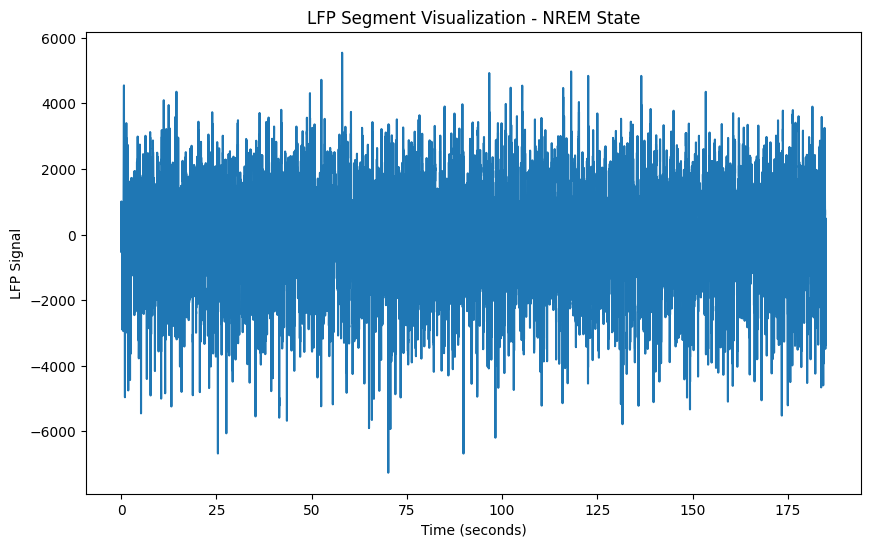

In [12]:
import matplotlib.pyplot as plt

state = 'NREM'  # The state you're interested in
segment_index = 10  # The segment index you want to visualize

# Check if the state and segment index are valid
if state in lfp and segment_index < segment_counts[state]:
    x = lfp[state][segment_index]
    t = np.arange(len(x)) / fs  # Time axis

    plt.figure(figsize=(10, 6))
    plt.plot(t, x)
    plt.xlabel('Time (seconds)')
    plt.ylabel('LFP Signal')
    plt.title(f'LFP Segment Visualization - {state} State')
    plt.show()
else:
    print(f"Data for state '{state}' with index {segment_index} is not available.")